<a href="https://colab.research.google.com/github/Eeaeau/Training-on-CUB_200_2011-dataset-with-detectron2/blob/master/Training%20on%20CUB_200_2011%20dataset%20with%20detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on CUB_200_2011 dataset with detectron2


<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">




# Install detectron2

In [3]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)

!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
!pip install wget
!pip install imantics 
!pip install tensorflow-tensorboard
!pip install tensorflow==1.14.0
!pip install future
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-1sdw17ty
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-1sdw17ty
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275302 sha256=ce42429b92bcb7f0204b1e321efb4a941890706d9d78b9135ac51c8fa24b16bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ueoi3g0y/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Train on a custom dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

## Prepare the dataset

In [0]:
import shutil
import wget

#!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/segmentations.tgz

url ="http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/segmentations.tgz"
pic_url ="http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz"

filename = wget.download(url)
pic_filename = wget.download(pic_url)




In [11]:
print(filename)
print(pic_filename)

!mkdir data

shutil.unpack_archive(filename, "data")
shutil.unpack_archive(pic_filename, "data")

segmentations (1).tgz
CUB_200_2011 (1).tgz
mkdir: cannot create directory ‘data’: File exists


In [12]:
!cd data && ls && cd CUB_200_2011 && ls
#!cd CUB_200_2011 && ls

attributes.txt	CUB_200_2011  segmentations
attributes	    image_class_labels.txt  parts
bounding_boxes.txt  images		    README
classes.txt	    images.txt		    train_test_split.txt


In [13]:
with open('data/CUB_200_2011/images.txt') as f:
    images_path = [(line.rstrip()).split() for line in f]

with open('data/CUB_200_2011/classes.txt') as f:
    classes_list = [(line.rstrip()).split() for line in f]

with open('data/CUB_200_2011/image_class_labels.txt') as f:
    class_label_list = [(line.rstrip()).split() for line in f]

with open('data/CUB_200_2011/bounding_boxes.txt') as f:
    bounding_boxes_list = [(line.rstrip()).split() for line in f]

3
['1', '001.Black_footed_Albatross']
['1', '1']


In [14]:
#'data/segmentations/'+(images_path[1][1])[:-4]+'png'

#x,y,w,h = float(bounding_boxes_list[0][1:])
x=float(bounding_boxes_list[0][1])


#print(bounding_boxes_list[0][1:])
#print(x,y,w,h)
print(type(x))


<class 'float'>


In [15]:
contours_collection = []

for path in images_path:
  #print('data/segmentations/'+(path[1])[:-4]+'.png')
  originalImage = cv2.imread('data/segmentations/'+(path[1])[:-4]+'.png')
  sourceImage = cv2.imread('data/CUB_200_2011/images/'+path[1])

  grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)

  (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
  
  contours, heirarchy = cv2.findContours(blackAndWhiteImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  contours_collection.append(contours)
  
print(contours_collection)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



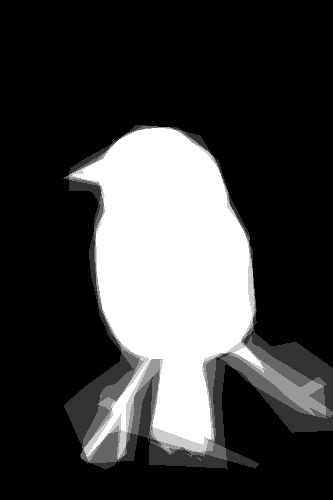

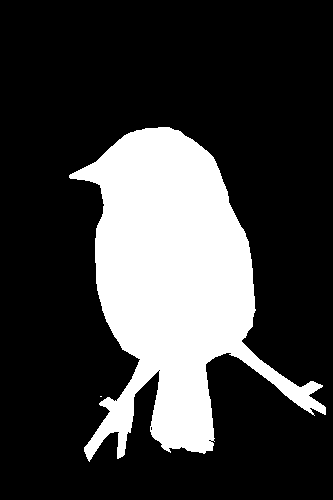

[array([[[100, 396]],

       [[101, 396]]], dtype=int32), array([[[158, 127]],

       [[157, 128]],

       [[145, 128]],

       ...,

       [[171, 128]],

       [[170, 128]],

       [[169, 127]]], dtype=int32), array([[[208, 440]],

       [[209, 439]],

       [[210, 439]],

       [[211, 440]],

       [[210, 441]],

       [[209, 441]]], dtype=int32), array([[[150, 427]],

       [[151, 426]],

       [[152, 427]],

       [[152, 429]],

       [[151, 430]],

       [[150, 429]]], dtype=int32), array([[[158, 370]],

       [[159, 369]],

       [[160, 370]],

       [[159, 371]]], dtype=int32)]


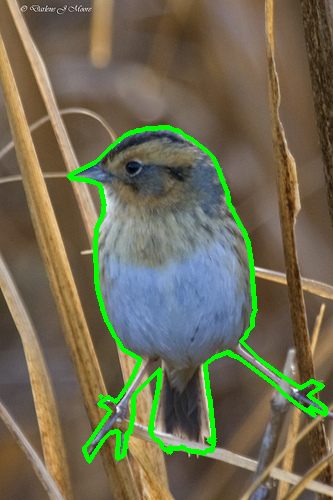

In [16]:

# ----------------Just for texting------------------

#for path in random.sample(images_path, 3):
path = images_path[7332]


originalImage = cv2.imread('data/segmentations/'+(path[1])[:-4]+'.png')
sourceImage = cv2.imread('data/CUB_200_2011/images/'+path[1])

grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)

cv2_imshow(grayImage)

(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)

cv2_imshow(blackAndWhiteImage)

contours, heirarchy = cv2.findContours(blackAndWhiteImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(contours)

cv2.drawContours(sourceImage, contours, -1, (0,255,0), 3)
cv2_imshow(sourceImage)

Convert dataset to COCO json format

In [20]:
import os
import numpy as np
import json


'\ndicts.append( {"info": info, \n               "images": [image], \n               "annotations": [annotation], \n               "licenses": [license],\n})\n\n\ndicts.append( {"name": "Sara",\n"languages": ["German", "Fench"],\n"married": False,\n"age": 31\n})\n\ndicts.append( {"name": "Bob",\n"languages": ["German", "Fench"],\n"married": False,\n"age": 31\n})\n\nwith open(\'person.json\', \'w\', encoding=\'utf-8\') as f:\n    json.dump(dicts, f, ensure_ascii=False, indent=4)\n\n\nwith open(\'person.json\') as f:\n  data = json.load(f)\n\n# Output: {\'name\': \'Bob\', \'languages\': [\'English\', \'Fench\']}\nprint(json.dumps(data, indent = 4, sort_keys=True))\n\n'

Set info

In [21]:
import datetime

info_dict = {
    "year": 2020, 
     "version": 0.1, 
     "description": "birdtectron", 
     "date_created": datetime.datetime.utcnow().isoformat(' ')
}

11788
{'year': 2020, 'version': 0.1, 'description': 'birdtectron', 'date_created': '2020-04-22 21:23:10.301951'}


Set images

In [22]:


image_dict = []

print("length of dataset: ", len(images_path))

for i in range(len(images_path)):
  temp_path = 'data/CUB_200_2011/images/'+ images_path[i][1]
  img = cv2.imread(temp_path, cv2.IMREAD_UNCHANGED)

  image_dict.append(
      {"id": int(images_path[i][0]), 
        "width": int(img.shape[1]), 
        "height": int(img.shape[0]), 
        "file_name": temp_path
  }
)



11788


In [23]:
# a check to see if everything is working as expected
print(image_dict[0])

{'id': 1, 'width': 500, 'height': 335, 'file_name': 'data/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'}


'\ncnt = contours_collection[0][0]\nx,y,w,h = cv2.boundingRect(cnt)\nprint(x,y,w,h)\n#print(cnt)\nA=cv2.contourArea(cnt)\nprint(A)\n'

Set annotations

In [24]:
# annotations ------------------
annotation_dict = []

n = 0

print(int(class_label_list[n][0]))

for contours in contours_collection:

  seg = []
  
  area=0

  #cnt = contours[0]
  # x,y,w,h = cv2.boundingRect(cnt)
  x,y,w,h = bounding_boxes_list[n][1:]
  #print(x,y,w,h)

  for cnt in contours:
    sub_seg = []
    area+=float(cv2.contourArea(cnt))
    for i in range(len(cnt)):
      sub_seg.append(float(cnt[i,0,0]))
      sub_seg.append(float(cnt[i,0,1]))
    
    seg.append(sub_seg)

  if(((len(sub_seg))%2)!=0):
    print(n, "odd")

  annotation_dict.append({
    "id": int(class_label_list[n][0]),
    "image_id": int(class_label_list[n][0]), 
    "category_id": int(class_label_list[n][1]),
    "segmentation": seg,
    "area": area, 
    "bbox": [float(x),float(y),float(w),float(h)],
    "iscrowd": 0
  })

  n += 1


1


In [25]:
#test to see if everything is working as expected

print(len(annotation_dict[7332]['segmentation']))
print(annotation_dict[7432])

5
{'id': 7433, 'image_id': 7433, 'category_id': 127, 'segmentation': [[274.0, 409.0, 272.0, 411.0], [167.0, 242.0, 166.0, 243.0, 165.0, 243.0, 164.0, 244.0, 163.0, 244.0, 162.0, 245.0, 160.0, 245.0, 159.0, 246.0, 158.0, 246.0, 145.0, 259.0, 144.0, 259.0, 142.0, 261.0, 141.0, 261.0, 136.0, 266.0, 135.0, 266.0, 134.0, 267.0, 133.0, 267.0, 131.0, 269.0, 130.0, 269.0, 126.0, 273.0, 125.0, 273.0, 123.0, 275.0, 121.0, 275.0, 121.0, 277.0, 120.0, 278.0, 119.0, 278.0, 118.0, 279.0, 117.0, 279.0, 116.0, 280.0, 115.0, 280.0, 114.0, 281.0, 116.0, 281.0, 117.0, 282.0, 119.0, 282.0, 120.0, 283.0, 122.0, 283.0, 123.0, 284.0, 124.0, 284.0, 125.0, 285.0, 131.0, 285.0, 132.0, 286.0, 134.0, 286.0, 135.0, 287.0, 136.0, 287.0, 137.0, 288.0, 137.0, 289.0, 148.0, 300.0, 148.0, 301.0, 157.0, 310.0, 157.0, 313.0, 159.0, 315.0, 159.0, 316.0, 160.0, 317.0, 160.0, 318.0, 161.0, 319.0, 161.0, 321.0, 162.0, 322.0, 162.0, 324.0, 163.0, 325.0, 163.0, 326.0, 164.0, 327.0, 164.0, 328.0, 165.0, 329.0, 165.0, 330.0, 166

Categories

In [26]:
# categories ------------------
categories_dict = []
for class_from_list in classes_list:
  
  categories_dict.append({
      "supercategory": "bird",
     "id": int(class_from_list[0]),
     "name": class_from_list[1]
     }
  )

#test
print(categories_dict[1])

{'supercategory': 'bird', 'id': 2, 'name': '002.Laysan_Albatross'}


Create complete dataset

In [0]:
custom_dataset = {
 "info": info_dict,
 "categories": categories_dict,
 "images": image_dict,
 "annotations": annotation_dict
}


Check dict

In [28]:
for d in custom_dataset['annotations']:

  seg_temp=d['segmentation'][0]

  if(((len(seg_temp))%2)!=0):
    print(d['id'], "odd")

  if(len(seg_temp)>=4):
    print(d['id'], "empty", seg_temp)


1 empty [186.0, 30.0, 185.0, 31.0, 180.0, 31.0, 179.0, 32.0, 174.0, 32.0, 173.0, 33.0, 169.0, 33.0, 168.0, 34.0, 165.0, 34.0, 164.0, 35.0, 162.0, 35.0, 161.0, 36.0, 160.0, 36.0, 159.0, 37.0, 158.0, 37.0, 157.0, 38.0, 156.0, 38.0, 155.0, 39.0, 153.0, 39.0, 152.0, 40.0, 151.0, 40.0, 150.0, 41.0, 149.0, 41.0, 148.0, 42.0, 147.0, 42.0, 146.0, 43.0, 144.0, 43.0, 143.0, 44.0, 141.0, 44.0, 140.0, 45.0, 139.0, 45.0, 138.0, 46.0, 136.0, 46.0, 132.0, 50.0, 131.0, 50.0, 127.0, 54.0, 126.0, 54.0, 124.0, 56.0, 123.0, 56.0, 122.0, 57.0, 121.0, 57.0, 119.0, 59.0, 119.0, 60.0, 111.0, 68.0, 110.0, 68.0, 104.0, 74.0, 104.0, 75.0, 103.0, 76.0, 103.0, 77.0, 102.0, 78.0, 102.0, 79.0, 101.0, 80.0, 101.0, 81.0, 100.0, 82.0, 100.0, 83.0, 99.0, 84.0, 99.0, 85.0, 98.0, 86.0, 98.0, 87.0, 97.0, 88.0, 97.0, 89.0, 96.0, 90.0, 96.0, 91.0, 95.0, 92.0, 95.0, 93.0, 94.0, 94.0, 94.0, 95.0, 93.0, 96.0, 93.0, 97.0, 92.0, 98.0, 92.0, 100.0, 91.0, 101.0, 91.0, 104.0, 90.0, 105.0, 90.0, 108.0, 89.0, 109.0, 89.0, 113.0, 88.0,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



empty [298.0, 98.0, 297.0, 99.0, 294.0, 99.0, 293.0, 100.0, 290.0, 100.0, 289.0, 101.0, 286.0, 101.0, 285.0, 102.0, 280.0, 102.0, 279.0, 103.0, 278.0, 103.0, 277.0, 104.0, 275.0, 104.0, 274.0, 105.0, 273.0, 105.0, 271.0, 107.0, 270.0, 107.0, 269.0, 108.0, 268.0, 108.0, 266.0, 110.0, 265.0, 110.0, 264.0, 111.0, 262.0, 111.0, 261.0, 112.0, 259.0, 112.0, 258.0, 113.0, 257.0, 113.0, 254.0, 116.0, 251.0, 116.0, 250.0, 117.0, 248.0, 117.0, 247.0, 118.0, 245.0, 118.0, 244.0, 119.0, 243.0, 119.0, 241.0, 121.0, 239.0, 121.0, 238.0, 122.0, 231.0, 122.0, 230.0, 123.0, 227.0, 123.0, 226.0, 124.0, 224.0, 124.0, 223.0, 125.0, 220.0, 125.0, 219.0, 126.0, 213.0, 126.0, 212.0, 127.0, 208.0, 127.0, 207.0, 128.0, 205.0, 128.0, 204.0, 129.0, 202.0, 129.0, 201.0, 130.0, 199.0, 130.0, 198.0, 131.0, 196.0, 131.0, 195.0, 132.0, 192.0, 132.0, 191.0, 131.0, 185.0, 131.0, 184.0, 132.0, 183.0, 131.0, 166.0, 131.0, 165.0, 130.0, 156.0, 130.0, 155.0, 129.0, 154.0, 129.0, 153.0, 128.0, 152.0, 128.0, 151.0, 127.0, 14

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 empty [374.0, 76.0, 373.0, 77.0, 363.0, 77.0, 360.0, 80.0, 359.0, 80.0, 358.0, 81.0, 357.0, 81.0, 344.0, 94.0, 344.0, 95.0, 335.0, 104.0, 335.0, 105.0, 326.0, 114.0, 326.0, 115.0, 325.0, 116.0, 323.0, 116.0, 322.0, 117.0, 321.0, 117.0, 320.0, 118.0, 318.0, 118.0, 317.0, 119.0, 315.0, 119.0, 314.0, 120.0, 313.0, 120.0, 312.0, 121.0, 310.0, 121.0, 309.0, 122.0, 308.0, 122.0, 307.0, 123.0, 305.0, 123.0, 304.0, 124.0, 302.0, 124.0, 301.0, 125.0, 298.0, 125.0, 297.0, 126.0, 295.0, 126.0, 294.0, 127.0, 292.0, 127.0, 291.0, 128.0, 290.0, 128.0, 289.0, 129.0, 287.0, 129.0, 286.0, 130.0, 285.0, 130.0, 284.0, 131.0, 282.0, 131.0, 281.0, 132.0, 279.0, 132.0, 278.0, 133.0, 277.0, 133.0, 276.0, 134.0, 274.0, 134.0, 273.0, 135.0, 270.0, 135.0, 269.0, 136.0, 267.0, 136.0, 266.0, 137.0, 264.0, 137.0, 263.0, 138.0, 261.0, 138.0, 260.0, 139.0, 258.0, 139.0, 257.0, 140.0, 254.0, 140.0, 253.0, 141.0, 251.0, 141.0, 250.0, 142.0, 248.0, 142.0, 247.0, 143.0, 246.0, 143.0, 245.0, 142.0, 243.0, 142.0, 242.0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[155.0, 83.0, 154.0, 84.0, 153.0, 84.0, 151.0, 86.0, 147.0, 86.0, 147.0, 87.0, 146.0, 88.0, 146.0, 90.0, 145.0, 91.0, 144.0, 90.0, 134.0, 90.0, 132.0, 92.0, 131.0, 92.0, 130.0, 91.0, 132.0, 93.0, 131.0, 94.0, 130.0, 94.0, 127.0, 97.0, 126.0, 97.0, 124.0, 99.0, 124.0, 111.0, 123.0, 112.0, 123.0, 114.0, 122.0, 115.0, 122.0, 118.0, 121.0, 119.0, 121.0, 125.0, 120.0, 126.0, 120.0, 141.0, 119.0, 142.0, 119.0, 145.0, 118.0, 146.0, 118.0, 150.0, 117.0, 151.0, 117.0, 154.0, 116.0, 155.0, 116.0, 159.0, 115.0, 160.0, 115.0, 162.0, 114.0, 163.0, 114.0, 165.0, 113.0, 166.0, 113.0, 169.0, 112.0, 170.0, 112.0, 171.0, 110.0, 173.0, 110.0, 174.0, 109.0, 175.0, 109.0, 176.0, 107.0, 178.0, 107.0, 179.0, 105.0, 181.0, 105.0, 182.0, 104.0, 183.0, 104.0, 184.0, 102.0, 186.0, 102.0, 187.0, 101.0, 188.0, 101.0, 189.0, 100.0, 190.0, 100.0, 191.0, 99.0, 192.0, 99.0, 193.0, 98.0, 194.0, 98.0, 195.0, 97.0, 196.0, 97.0, 197.0, 96.0, 198.0, 96.0, 200.0, 95.0, 201.0, 95.0, 202.0, 94.0, 203.0, 94.0, 205.0, 93.0, 206

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




6876 empty [253.0, 133.0, 253.0, 136.0, 252.0, 137.0, 251.0, 136.0, 247.0, 136.0, 247.0, 138.0, 246.0, 139.0, 241.0, 139.0, 240.0, 140.0, 239.0, 140.0, 236.0, 143.0, 236.0, 144.0, 235.0, 145.0, 233.0, 145.0, 232.0, 146.0, 231.0, 146.0, 231.0, 150.0, 229.0, 152.0, 229.0, 154.0, 228.0, 155.0, 222.0, 155.0, 221.0, 156.0, 220.0, 156.0, 219.0, 157.0, 218.0, 157.0, 217.0, 158.0, 214.0, 158.0, 213.0, 159.0, 209.0, 159.0, 208.0, 160.0, 205.0, 160.0, 204.0, 161.0, 203.0, 161.0, 201.0, 163.0, 200.0, 163.0, 198.0, 165.0, 197.0, 165.0, 195.0, 167.0, 194.0, 167.0, 193.0, 168.0, 192.0, 168.0, 191.0, 169.0, 190.0, 169.0, 189.0, 170.0, 188.0, 170.0, 187.0, 171.0, 186.0, 171.0, 185.0, 172.0, 184.0, 172.0, 183.0, 173.0, 182.0, 173.0, 181.0, 174.0, 180.0, 174.0, 178.0, 176.0, 177.0, 176.0, 173.0, 180.0, 172.0, 180.0, 165.0, 187.0, 164.0, 187.0, 162.0, 189.0, 161.0, 189.0, 160.0, 190.0, 159.0, 190.0, 156.0, 193.0, 155.0, 193.0, 151.0, 197.0, 150.0, 197.0, 148.0, 199.0, 147.0, 199.0, 134.0, 212.0, 134.0, 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Registrate as detectron dataset

In [29]:
import random
#!cd datamkdir 

!touch my_dataset.json
!ls



with open('my_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(custom_dataset, f, ensure_ascii=False)



'CUB_200_2011 (1).tgz'	 input.jpg	   sample_data
 CUB_200_2011.tgz	 my_dataset.json  'segmentations (1).tgz'
 data			 output		   segmentations.tgz


In [0]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

detectron2.data.DatasetCatalog.clear()

register_coco_instances("BirdsNStuff", {}, "my_dataset.json", "")

#converted_dict = detectron2.data.datasets.coco.load_coco_json('my_dataset.json', 'data')



In [31]:
#print(MetadataCatalog.list)
my_dataset_metadata=MetadataCatalog.get("BirdsNStuff")

my_dataset_dicts = DatasetCatalog.get("BirdsNStuff")

print(my_dataset_metadata)
#print(my_dataset_dicts["file_name"])

[04/22 21:24:33 d2.data.datasets.coco]: Loading my_dataset.json takes 1.69 seconds.
[04/22 21:24:34 d2.data.datasets.coco]: Loaded 11788 images in COCO format from my_dataset.json
Metadata(evaluator_type='coco', image_root='', json_file='my_dataset.json', name='BirdsNStuff', thing_classes=['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_bille

{'file_name': 'data/CUB_200_2011/images/170.Mourning_Warbler/Mourning_Warbler_0082_166574.jpg', 'height': 475, 'width': 429, 'image_id': 9977, 'annotations': [{'iscrowd': 0, 'bbox': [171.0, 80.0, 192.0, 309.0], 'category_id': 169, 'segmentation': [[203.0, 82.0, 203.0, 84.0, 204.0, 85.0, 204.0, 86.0, 205.0, 87.0, 205.0, 91.0, 206.0, 92.0, 206.0, 93.0, 207.0, 94.0, 207.0, 95.0, 208.0, 96.0, 208.0, 98.0, 209.0, 99.0, 209.0, 100.0, 210.0, 101.0, 210.0, 102.0, 209.0, 103.0, 208.0, 103.0, 207.0, 102.0, 206.0, 102.0, 205.0, 101.0, 204.0, 101.0, 202.0, 99.0, 201.0, 99.0, 200.0, 98.0, 199.0, 98.0, 198.0, 97.0, 197.0, 98.0, 196.0, 98.0, 195.0, 97.0, 194.0, 97.0, 193.0, 96.0, 192.0, 96.0, 191.0, 95.0, 190.0, 95.0, 191.0, 96.0, 191.0, 97.0, 194.0, 100.0, 194.0, 101.0, 203.0, 110.0, 203.0, 111.0, 204.0, 112.0, 204.0, 113.0, 205.0, 114.0, 205.0, 116.0, 206.0, 117.0, 206.0, 119.0, 208.0, 121.0, 208.0, 123.0, 207.0, 124.0, 207.0, 125.0, 206.0, 126.0, 206.0, 127.0, 205.0, 128.0, 205.0, 130.0, 204.0, 13

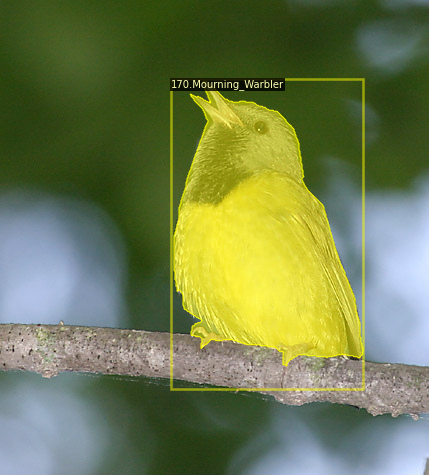

{'file_name': 'data/CUB_200_2011/images/076.Dark_eyed_Junco/Dark_Eyed_Junco_0010_66649.jpg', 'height': 330, 'width': 500, 'image_id': 4381, 'annotations': [{'iscrowd': 0, 'bbox': [145.0, 84.0, 231.0, 229.0], 'category_id': 75, 'segmentation': [[324.0, 84.0, 323.0, 85.0, 319.0, 85.0, 318.0, 86.0, 316.0, 86.0, 315.0, 87.0, 313.0, 87.0, 312.0, 88.0, 310.0, 88.0, 309.0, 89.0, 308.0, 89.0, 302.0, 95.0, 302.0, 96.0, 298.0, 100.0, 298.0, 101.0, 293.0, 106.0, 293.0, 107.0, 289.0, 111.0, 289.0, 112.0, 288.0, 113.0, 288.0, 114.0, 287.0, 115.0, 287.0, 118.0, 286.0, 119.0, 286.0, 120.0, 285.0, 121.0, 285.0, 125.0, 284.0, 126.0, 284.0, 127.0, 283.0, 128.0, 283.0, 129.0, 282.0, 130.0, 282.0, 132.0, 281.0, 133.0, 281.0, 135.0, 278.0, 138.0, 278.0, 139.0, 273.0, 144.0, 272.0, 144.0, 265.0, 151.0, 264.0, 151.0, 259.0, 156.0, 258.0, 156.0, 254.0, 160.0, 253.0, 160.0, 249.0, 164.0, 248.0, 164.0, 244.0, 168.0, 243.0, 168.0, 239.0, 172.0, 238.0, 172.0, 233.0, 177.0, 232.0, 177.0, 230.0, 179.0, 229.0, 179.0

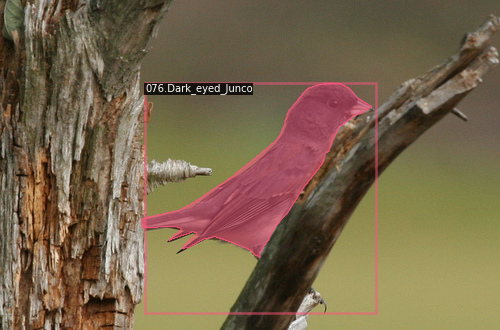

{'file_name': 'data/CUB_200_2011/images/136.Barn_Swallow/Barn_Swallow_0049_130181.jpg', 'height': 375, 'width': 500, 'image_id': 7957, 'annotations': [{'iscrowd': 0, 'bbox': [27.0, 112.0, 290.0, 168.0], 'category_id': 135, 'segmentation': [[271.0, 114.0, 270.0, 115.0, 265.0, 115.0, 258.0, 122.0, 257.0, 122.0, 255.0, 124.0, 254.0, 124.0, 251.0, 127.0, 251.0, 128.0, 250.0, 129.0, 250.0, 130.0, 249.0, 131.0, 249.0, 132.0, 248.0, 133.0, 248.0, 134.0, 247.0, 135.0, 247.0, 137.0, 246.0, 138.0, 246.0, 140.0, 245.0, 141.0, 245.0, 143.0, 244.0, 144.0, 244.0, 146.0, 243.0, 147.0, 243.0, 153.0, 242.0, 154.0, 242.0, 155.0, 241.0, 156.0, 241.0, 160.0, 240.0, 161.0, 239.0, 161.0, 237.0, 163.0, 237.0, 164.0, 236.0, 165.0, 236.0, 166.0, 234.0, 168.0, 234.0, 169.0, 233.0, 170.0, 232.0, 170.0, 229.0, 173.0, 228.0, 173.0, 225.0, 176.0, 224.0, 176.0, 221.0, 179.0, 220.0, 179.0, 212.0, 187.0, 208.0, 187.0, 207.0, 188.0, 204.0, 188.0, 203.0, 189.0, 201.0, 189.0, 199.0, 191.0, 198.0, 191.0, 197.0, 192.0, 196

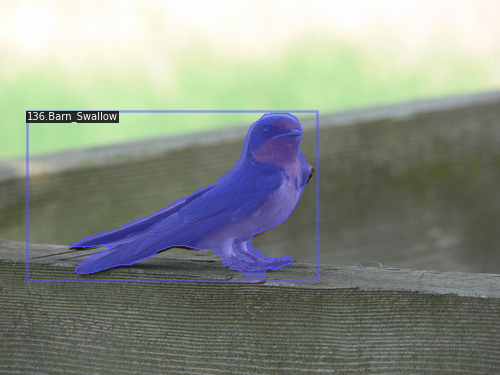

"\n!touch coco_dataset.json\n\nwith open('coco_dataset.json', 'w', encoding='utf-8') as f:\n    json.dump(converted_dict, f, ensure_ascii=False)"

In [32]:


#from PIL import Image # Notice the 'from PIL' at the start of the line


from detectron2.utils.visualizer import Visualizer

for d in random.sample(my_dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


"""
!touch coco_dataset.json

with open('coco_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(converted_dict, f, ensure_ascii=False)"""

In [0]:

import tensorflow as tf
import datetime

#%load_ext tensorboard
#%tensorboard --logdir output

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.model_zoo import model_zoo



cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("BirdsNStuff",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # faster, and good enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 200  # full dataset

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/22 22:11:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (201, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (201,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (800, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (800,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (200, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (200,) in the model! Skipped.


[04/22 22:11:18 d2.engine.train_loop]: Starting training from iteration 0
[04/22 22:11:26 d2.utils.events]:  eta: 10:41:25  iter: 19  total_loss: 5.769  loss_cls: 4.996  loss_box_reg: 0.074  loss_mask: 0.692  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.4070  data_time: 0.0193  lr: 0.000005  max_mem: 4687M
[04/22 22:11:34 d2.utils.events]:  eta: 10:33:33  iter: 39  total_loss: 5.458  loss_cls: 4.681  loss_box_reg: 0.073  loss_mask: 0.694  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.3908  data_time: 0.0077  lr: 0.000010  max_mem: 4902M
[04/22 22:11:41 d2.utils.events]:  eta: 10:22:38  iter: 59  total_loss: 4.868  loss_cls: 4.091  loss_box_reg: 0.072  loss_mask: 0.693  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.3798  data_time: 0.0074  lr: 0.000015  max_mem: 4902M
[04/22 22:11:48 d2.utils.events]:  eta: 10:19:41  iter: 79  total_loss: 3.391  loss_cls: 2.605  loss_box_reg: 0.083  loss_mask: 0.693  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.3769  data_time: 0.0068 

Make prediction

In [0]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set the testing threshold for this model
cfg.DATASETS.TEST = ("BirdsNStuff", )
predictor = DefaultPredictor(cfg)


In [0]:
print(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))
print(cfg.DATASETS.TRAIN[0])

In [0]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer


for d in random.sample(my_dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    
    v = Visualizer(im[:, :, ::-1],
                   MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])



**------------------------------Stop----------------------------------**

In [0]:



!wget https://www.norfolkwildlifetrust.org.uk/getmedia/e4cc6865-3d5c-4dde-9f0e-f795e20f8d0a/Common-Tern-on-post,-NWT-Barton-Broad,-Elizabeth-Dack,-10-May-2015-(Small).JPG.aspx?width=762 -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)


outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])










